In [2]:
import re
import netCDF4
from tqdm import tqdm
seed_value = 7
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import pandas as pd
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
myFmt_date = DateFormatter('%Y/%m/%d')
myFmt_time = DateFormatter('%H:%M')
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Open the NetCDF file
file_path = '/home/mnedal/TEC/sci_xrsf-l2-avg1m_g16_s20170207_e20230809_v2-2-0.nc'
nc_file = netCDF4.Dataset(file_path, 'r')

In [23]:
nc_file

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: ACDD-1.3, Spase v2.2.6
    title: L2 XRS 1 minute average
    summary: The EXIS X-Ray Sensor (XRS) measures in a short wavelength channel (XRS-A) between 0.05 and 0.4 nm and in a longer wavelength channel (XRS-B) between 0.1 and 0.8 nm. The X-ray flux average product consists of 1 minute averages of the 1-s X-ray solar measurements. Flux is provided with and without electron contamination removed.
    keywords: NumericalData.MeasurementType.Irradiance
    keywords_vocabulary: SPASE: Space Physics Archive Search and Extract Data Model version 2.2.6, GCMD: NASA Global Change Master Directory (GCMD) Earth Science Keywords version 8.5
    naming_authority: gov.nesdis.noaa
    history: See algorithm information.
    source: GOES-R EXIS/XRS L2 xrsf-l2-flx1s
    processing_level: Level 2
    processing_level_description: Derived products
    license: These data may be redistributed and used 

In [17]:
nc_file.variables.keys()

dict_keys(['xrsa_flux', 'xrsa_flux_observed', 'xrsa_flux_electrons', 'xrsb_flux', 'xrsb_flux_observed', 'xrsb_flux_electrons', 'xrsa_flag', 'xrsb_flag', 'xrsa_num', 'xrsb_num', 'time', 'xrsa_flag_excluded', 'xrsb_flag_excluded', 'au_factor', 'corrected_current_xrsb2', 'roll_angle', 'xrsa1_flux', 'xrsa1_flux_observed', 'xrsa1_flux_electrons', 'xrsa2_flux', 'xrsa2_flux_observed', 'xrsa2_flux_electrons', 'xrsb1_flux', 'xrsb1_flux_observed', 'xrsb1_flux_electrons', 'xrsb2_flux', 'xrsb2_flux_observed', 'xrsb2_flux_electrons', 'xrs_primary_chan', 'xrsa1_flag', 'xrsa2_flag', 'xrsb1_flag', 'xrsb2_flag', 'xrsa1_num', 'xrsa2_num', 'xrsb1_num', 'xrsb2_num', 'xrsa1_flag_excluded', 'xrsa2_flag_excluded', 'xrsb1_flag_excluded', 'xrsb2_flag_excluded', 'yaw_flip_flag'])

In [18]:
nc_file.variables['xrsa_flux']

<class 'netCDF4._netCDF4.Variable'>
float32 xrsa_flux(time)
    _FillValue: -9999.0
    long_name: XRS-A primary average flux.
    comments: Electron contamination has been removed. xrsa_flux =  xrsa_flux_observed - xrsa_flux_electrons
    units: W/m2
    valid_min: 1e-09
    valid_max: 0.003
    ancillary_variables: xrsa_flag xrsa_num xrsa_flag_excluded
unlimited dimensions: time
current shape = (3420000,)
filling on

In [19]:
nc_file.variables['time']

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    _FillValue: -9999.0
    long_name: Record start time, neglecting leap seconds.
    units: seconds since 2000-01-01 12:00:00
unlimited dimensions: time
current shape = (3420000,)
filling on

In [20]:
# Access the 'time' variable
time_variable = nc_file.variables['time']

# Get the base datetime
base_datetime = datetime(2000, 1, 1, 12, 0, 0)

# Convert time values to datetimes using a loop
time_values = time_variable[:]
datetimes = []

with tqdm(total=len(time_values), desc='Converting times') as pbar:

    for time_value in time_values:
        datetime_value = base_datetime + timedelta(seconds=int(time_value))
        datetimes.append(datetime_value)
        
        pbar.update(1)

Converting times: 100%|███████████████████████████████████████████████████| 3420000/3420000 [00:10<00:00, 334637.46it/s]


In [24]:
df = pd.DataFrame({
                    'times': datetimes, 
                    'xrsa_flux': nc_file.variables['xrsa_flux'][:].data, 
                    'xrsb_flux': nc_file.variables['xrsb_flux'][:].data
                })

# Set the 'times' column as the index
df.set_index('times', inplace=True)

# Close the NetCDF file
nc_file.close()

In [25]:
df = df.replace(-9999.0, np.nan)

<AxesSubplot:xlabel='times'>

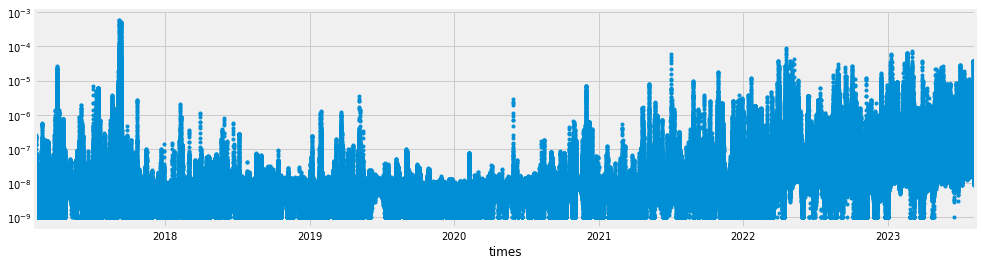

In [26]:
df['xrsa_flux'].plot(style='.', logy=True, figsize=[15,4])

In [27]:
df.head()

,xrsa_flux,xrsb_flux
times,,
2017-02-07 00:00:00,2.949822e-08,7.072423e-08
2017-02-07 00:01:00,2.716477e-08,6.869706e-08
2017-02-07 00:02:00,2.996076e-08,6.933664e-08
2017-02-07 00:03:00,3.124979e-08,6.796333e-08
2017-02-07 00:04:00,3.095799e-08,6.928261e-08


In [28]:
# resampling into hourly-avg data
df_xrs = df.resample('1H').mean()

In [29]:
df_xrs.head()

,xrsa_flux,xrsb_flux
times,,
2017-02-07 00:00:00,2.586590e-08,6.630512e-08
2017-02-07 01:00:00,1.278704e-08,4.607524e-08
2017-02-07 02:00:00,3.210202e-09,3.585645e-08
2017-02-07 03:00:00,1.050583e-09,3.514286e-08
2017-02-07 04:00:00,1.000000e-09,3.406276e-08


In [226]:
df_xrs.tail()

,xrsa_flux,xrsb_flux
times,,
2023-08-09 19:00:00,3.893654e-08,1.135600e-06
2023-08-09 20:00:00,3.022890e-08,1.021175e-06
2023-08-09 21:00:00,2.134851e-08,8.630795e-07
2023-08-09 22:00:00,1.722215e-08,8.383618e-07
2023-08-09 23:00:00,1.748711e-08,9.543502e-07


<AxesSubplot:xlabel='times'>

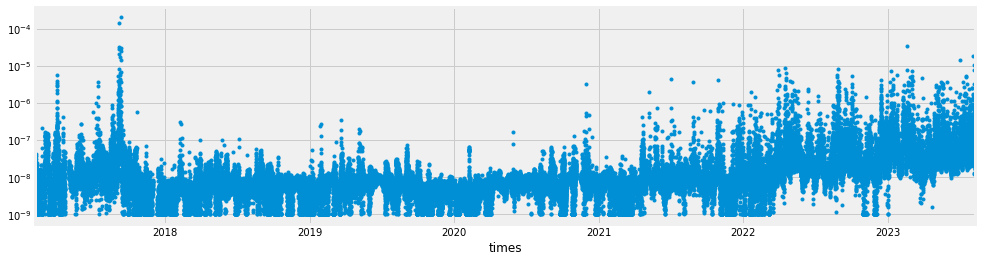

In [30]:
df_xrs['xrsa_flux'].plot(style='.', logy=True, figsize=[15,4])

In [31]:
# Define the datetime range for the sub DataFrame
start_date = '2017-02-07 00:00:00'
end_date = '2023-07-26 23:00:00'

# Create the sub DataFrame using boolean indexing
sub_df_xrs = df_xrs[(df_xrs.index >= start_date) & (df_xrs.index <= end_date)]
sub_df_xrs = sub_df_xrs.astype('float64')

<AxesSubplot:xlabel='times'>

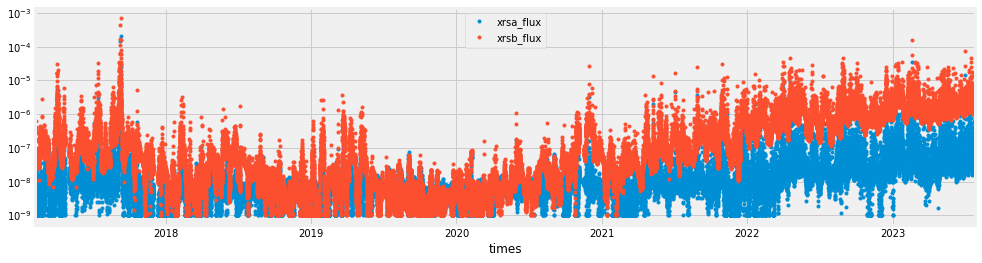

In [32]:
sub_df_xrs[['xrsa_flux','xrsb_flux']].plot(style='.', logy=True, figsize=[15,4])

In [33]:
len(sub_df_xrs)

56664

In [34]:
# Read the text file and create a DataFrame using regular expressions to split columns
with open('/home/mnedal/TEC/omni_f10index.txt', 'r') as f:
    lines = f.readlines()

# Assuming whitespace is used to separate columns
data = [re.split(r'\s+', line.strip()) for line in lines]
df_F10 = pd.DataFrame(data)

In [35]:
df_F10.head()

,0,1,2,3
0,2000,38,0,177.0
1,2000,38,1,177.0
2,2000,38,2,177.0
3,2000,38,3,177.0
4,2000,38,4,177.0


In [36]:
df_F10.columns = ['year', 'doy', 'hour', 'f10_index']

# Insert an empty column named 'Datetime' with NaN values
df_F10.insert(loc=0, column='Datetime', value=pd.NA)

In [37]:
df_F10.head()

,Datetime,year,doy,hour,f10_index
0,<NA>,2000,38,0,177.0
1,<NA>,2000,38,1,177.0
2,<NA>,2000,38,2,177.0
3,<NA>,2000,38,3,177.0
4,<NA>,2000,38,4,177.0


In [38]:
# Convert from DOY to datetime
with tqdm(total=len(df_F10), desc='Converting DOY to datetime') as pbar:

    for i in range(len(df_F10)):
        year = df_F10['year'][i]
        doy = df_F10['doy'][i]
        hh = df_F10['hour'][i]

        new_date = datetime.strptime(str(int(year))+str(' ')+str(int(doy)), '%Y %j')
        #new_datetime = new_date.strftime('%Y/%m/%d %H:%M:%S')
        df_F10['Datetime'][i] = new_date + timedelta(hours=int(hh))
        
        pbar.update(1)

Converting DOY to datetime: 100%|█████████████████████████████████████████████| 205704/205704 [00:35<00:00, 5762.14it/s]


In [39]:
df_F10.drop({'year','doy','hour'}, axis=1, inplace=True)
df_F10.set_index('Datetime', inplace=True)
df_F10 = df_F10.astype('float64')
df_F10 = df_F10.replace(999.9, np.nan)
sub_df_f10 = df_F10[(df_F10.index >= start_date) & (df_F10.index <= end_date)]

In [40]:
sub_df_f10.head(3)

,f10_index
Datetime,
2017-02-07 00:00:00,70.1
2017-02-07 01:00:00,70.1
2017-02-07 02:00:00,70.1


In [41]:
sub_df_f10.tail(3)

,f10_index
Datetime,
2023-07-26 21:00:00,172.6
2023-07-26 22:00:00,172.6
2023-07-26 23:00:00,172.6


<AxesSubplot:xlabel='Datetime'>

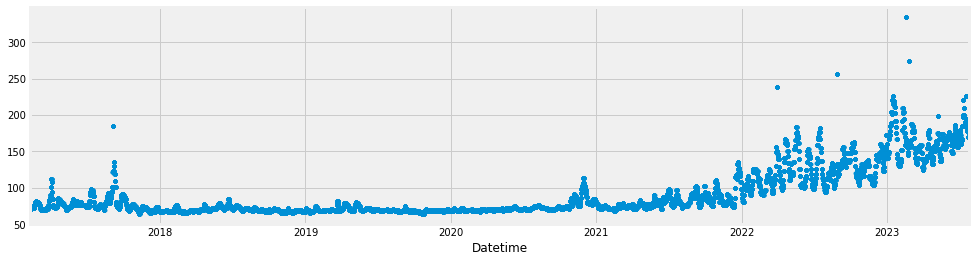

In [42]:
sub_df_f10['f10_index'].plot(style='.', figsize=[15,4])

<AxesSubplot:xlabel='times'>

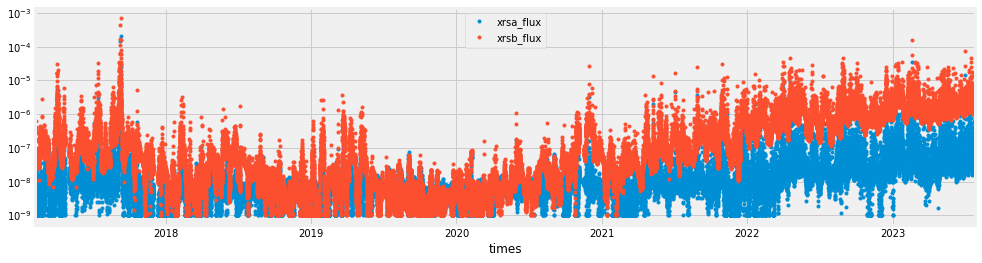

In [43]:
sub_df_xrs[['xrsa_flux','xrsb_flux']].plot(style='.', logy=True, figsize=[15,4])

In [44]:
if pd.isna(sub_df_xrs).any().all():
    sub_df_xrs = sub_df_xrs.interpolate()

if pd.isna(sub_df_f10).any().all():
    sub_df_f10 = sub_df_f10.interpolate()

x1 = np.log10(sub_df_xrs['xrsa_flux'])
x2 = np.log10(sub_df_xrs['xrsb_flux'])
y = sub_df_f10['f10_index']

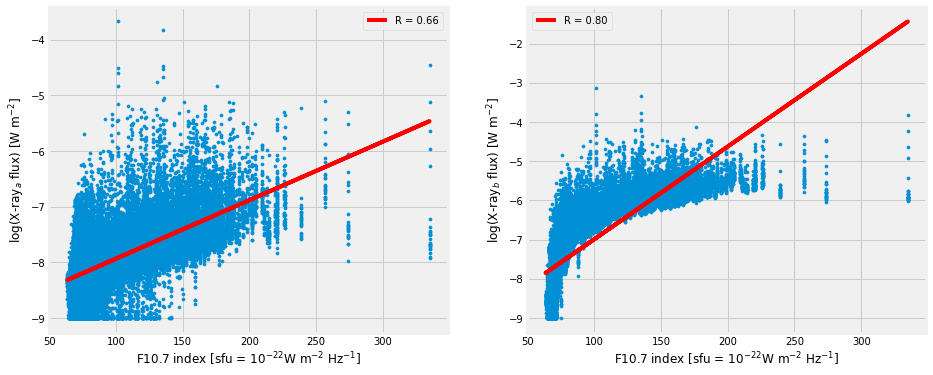

In [45]:
y1 = np.log10(sub_df_xrs['xrsa_flux'])
y2 = np.log10(sub_df_xrs['xrsb_flux'])
x = sub_df_f10['f10_index']

fig = plt.figure(figsize=[14,6])
ax = fig.add_subplot(121)
ax.scatter(x, y1, s=10)

m1, b1 = np.polyfit(x, y1, 1)
r_val1 = np.corrcoef(x, y1)
ax.plot(x, m1*x + b1, '-r', label=f'R = {r_val1[0,1]:.2f}')

ax.set_ylabel('log(X-ray$_a$ flux) [W m$^{-2}$]')
ax.set_xlabel('F10.7 index [sfu = 10$^{-22}$W m$^{-2}$ Hz$^{-1}$]')
ax.legend(loc='best')



ax = fig.add_subplot(122)
ax.scatter(x, y2, s=10)

m2, b2 = np.polyfit(x, y2, 1)
r_val2 = np.corrcoef(x, y2)
ax.plot(x, m2*x + b2, '-r', label=f'R = {r_val2[0,1]:.2f}')

ax.set_ylabel('log(X-ray$_b$ flux) [W m$^{-2}$]')
ax.set_xlabel('F10.7 index [sfu = 10$^{-22}$W m$^{-2}$ Hz$^{-1}$]')
ax.legend(loc='best')
plt.show()

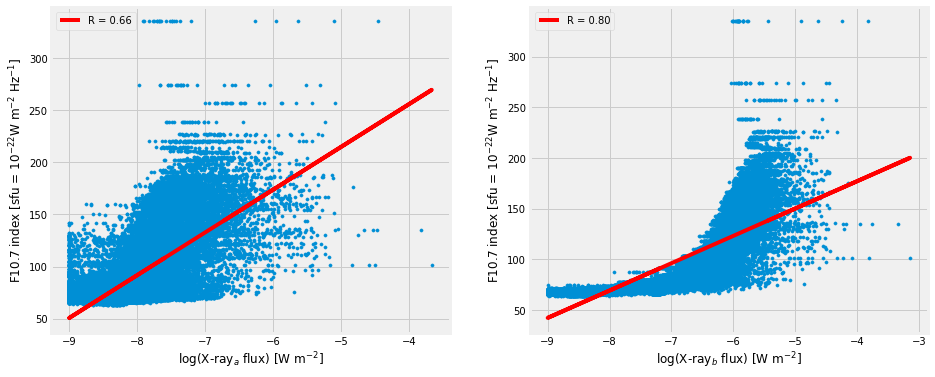

In [46]:
fig = plt.figure(figsize=[14,6])
ax = fig.add_subplot(121)
ax.scatter(x1, y, s=10)

m1, b1 = np.polyfit(x1, y, 1)
r_val1 = np.corrcoef(x1, y)
ax.plot(x1, m1*x1 + b1, '-r', label=f'R = {r_val1[0,1]:.2f}')

ax.set_xlabel('log(X-ray$_a$ flux) [W m$^{-2}$]')
ax.set_ylabel('F10.7 index [sfu = 10$^{-22}$W m$^{-2}$ Hz$^{-1}$]')
ax.legend(loc='best')



ax = fig.add_subplot(122)
ax.scatter(x2, y, s=10)

m2, b2 = np.polyfit(x2, y, 1)
r_val2 = np.corrcoef(x2, y)
ax.plot(x2, m2*x2 + b2, '-r', label=f'R = {r_val2[0,1]:.2f}')

ax.set_xlabel('log(X-ray$_b$ flux) [W m$^{-2}$]')
ax.set_ylabel('F10.7 index [sfu = 10$^{-22}$W m$^{-2}$ Hz$^{-1}$]')
ax.legend(loc='best')


#plt.savefig(f'{main_folder}/{which_data}/{experiment_folder}/scatterplot_obs_vs_model_valset_2dayahead.pdf', bbox_inches='tight')
plt.show()

In [47]:
x1

times
2017-02-07 00:00:00   -7.587272
2017-02-07 01:00:00   -7.893230
2017-02-07 02:00:00   -8.493468
2017-02-07 03:00:00   -8.978569
2017-02-07 04:00:00   -9.000000
                         ...   
2023-07-26 19:00:00   -7.433631
2023-07-26 20:00:00   -7.483200
2023-07-26 21:00:00   -7.137350
2023-07-26 22:00:00   -6.811205
2023-07-26 23:00:00   -6.730682
Freq: H, Name: xrsa_flux, Length: 56664, dtype: float64

In [48]:
# Read the pickle file into a DataFrame
years = np.arange(2014, 2024)
all_dfs = []

for i, year in enumerate(years):
    print(f'{i} working on {year} ...')
    df = pd.read_pickle(f'./{year}/all_{year}.pkl')
    all_dfs.append(df)

# Combine the list of DataFrames into a single DataFrame
combined_dataframe = pd.concat(all_dfs)

0 working on 2014 ...
1 working on 2015 ...
2 working on 2016 ...
3 working on 2017 ...
4 working on 2018 ...
5 working on 2019 ...
6 working on 2020 ...
7 working on 2021 ...
8 working on 2022 ...
9 working on 2023 ...


In [49]:
# resampling into hourly-avg data
euv_resampled = combined_dataframe.resample('1H').mean()

In [50]:
euv_resampled.head()

,YEAR,DOY,SOD,Q_0,CH_18,CH_26,CH_30,CH_36
Datetime,,,,,,,,
2014-07-01 00:00:00,2014.0,182.0,1799.942291,0.000499,0.001158,0.000623,0.001102,0.000284
2014-07-01 01:00:00,2014.0,182.0,5399.943609,0.000565,0.001168,0.000626,0.001101,0.000293
2014-07-01 02:00:00,2014.0,182.0,8999.944662,0.000495,0.001171,0.000630,0.001105,0.000296
2014-07-01 03:00:00,2014.0,182.0,12599.945499,0.000456,0.001167,0.000626,0.001105,0.000362
2014-07-01 04:00:00,2014.0,182.0,16199.946174,0.000503,0.001163,0.000624,0.001110,0.000239


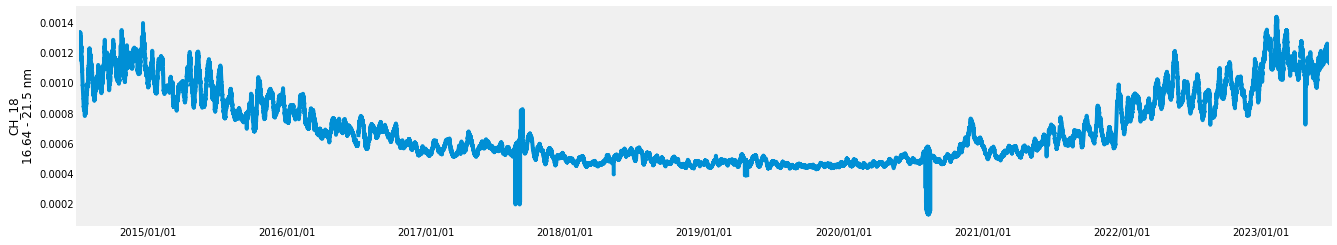

In [52]:
col_name = 'CH_18'

fig = plt.figure(figsize=[20,4])
ax = fig.add_subplot(111)
ax.plot(euv_resampled.index, euv_resampled[col_name])

if col_name == 'Q_0':
    ax.set_ylabel('Q_0\n0.1 - 7 nm')
elif col_name == 'CH_18':
    ax.set_ylabel('CH_18\n16.64 - 21.5 nm')
elif col_name == 'CH_26':
    ax.set_ylabel('CH_26\n22.28 - 28.78 nm')
elif col_name == 'CH_30':
    ax.set_ylabel('CH_30\n27.16 - 33.8 nm')
elif col_name == 'CH_36':
    ax.set_ylabel('CH_36\n33.3 - 40.04 nm')

#ax.set_yscale('log')
ax.set_xlim(left=euv_resampled.index[0], right=euv_resampled.index[-1])
#ax.set_xlim(left=pd.Timestamp('2014-07-01 00:00'), right=pd.Timestamp('2015-07-01 00:00'))
ax.grid()
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%Y/%m/%d'))
plt.show()

In [98]:
# Define the datetime range for the sub DataFrame
start_date = '2017-02-07 00:00:00'
end_date = '2023-06-30 23:00:00'

# Create the sub DataFrame using boolean indexing, to match the lengths
sub_df_euv = euv_resampled[(euv_resampled.index >= start_date) & (euv_resampled.index <= end_date)]
sub_df_euv = sub_df_euv.astype('float64')

sub_df_xrs = sub_df_xrs[(sub_df_xrs.index >= start_date) & (sub_df_xrs.index <= end_date)]
sub_df_xrs = sub_df_xrs.astype('float64')

sub_df_f10 = sub_df_f10['f10_index'][(sub_df_f10['f10_index'].index >= start_date) & (sub_df_f10['f10_index'].index <= end_date)]
sub_df_f10 = sub_df_f10.astype('float64')

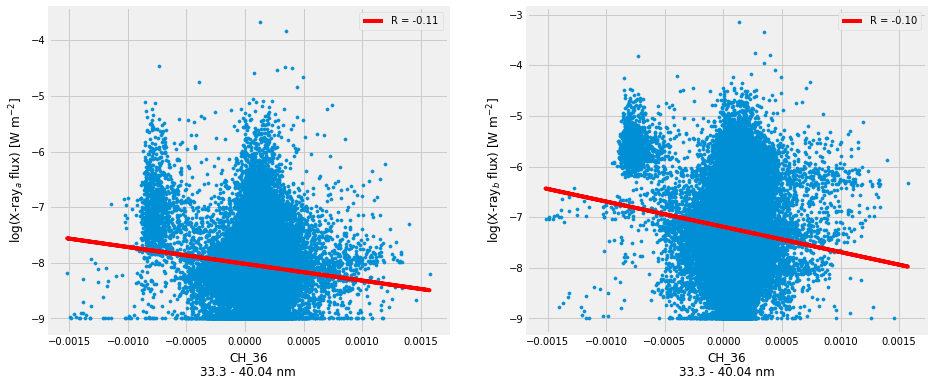

In [114]:
col_name = 'CH_36'

y1 = np.log10(sub_df_xrs['xrsa_flux'])
y2 = np.log10(sub_df_xrs['xrsb_flux'])
x = sub_df_euv[col_name]
#x = np.log10(sub_df_euv[col_name])
x = x.interpolate(method='linear', axis=0) # fill the nans


fig = plt.figure(figsize=[14,6])
ax = fig.add_subplot(121)
ax.scatter(x, y1, s=10)

m1, b1 = np.polyfit(x, y1, 1)
r_val1 = np.corrcoef(x, y1)
ax.plot(x, m1*x + b1, '-r', label=f'R = {r_val1[0,1]:.2f}')

if col_name == 'Q_0':
    ax.set_xlabel('log Q_0\n0.1 - 7 nm')
elif col_name == 'CH_18':
    ax.set_xlabel('CH_18\n16.64 - 21.5 nm')
elif col_name == 'CH_26':
    ax.set_xlabel('CH_26\n22.28 - 28.78 nm')
elif col_name == 'CH_30':
    ax.set_xlabel('CH_30\n27.16 - 33.8 nm')
elif col_name == 'CH_36':
    ax.set_xlabel('CH_36\n33.3 - 40.04 nm')

ax.set_ylabel('log(X-ray$_a$ flux) [W m$^{-2}$]')
ax.legend(loc='best')



ax = fig.add_subplot(122)
ax.scatter(x, y2, s=10)

m2, b2 = np.polyfit(x, y2, 1)
r_val2 = np.corrcoef(x, y2)
ax.plot(x, m2*x + b2, '-r', label=f'R = {r_val2[0,1]:.2f}')

if col_name == 'Q_0':
    ax.set_xlabel('log Q_0\n0.1 - 7 nm')
elif col_name == 'CH_18':
    ax.set_xlabel('CH_18\n16.64 - 21.5 nm')
elif col_name == 'CH_26':
    ax.set_xlabel('CH_26\n22.28 - 28.78 nm')
elif col_name == 'CH_30':
    ax.set_xlabel('CH_30\n27.16 - 33.8 nm')
elif col_name == 'CH_36':
    ax.set_xlabel('CH_36\n33.3 - 40.04 nm')

ax.set_ylabel('log(X-ray$_b$ flux) [W m$^{-2}$]')
ax.legend(loc='best')
plt.show()

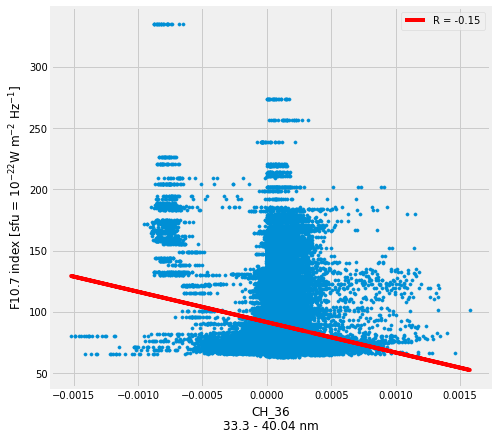

In [109]:
col_name = 'CH_36'

y = sub_df_f10.copy()
x = sub_df_euv[col_name]
#x = np.log10(sub_df_euv[col_name])
x = x.interpolate(method='linear', axis=0) # fill the nans


fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111)
ax.scatter(x, y, s=10)

m, b = np.polyfit(x, y, 1)
r_val = np.corrcoef(x, y)
ax.plot(x, m*x + b, '-r', label=f'R = {r_val[0,1]:.2f}')

if col_name == 'Q_0':
    ax.set_xlabel('log Q_0\n0.1 - 7 nm')
elif col_name == 'CH_18':
    ax.set_xlabel('CH_18\n16.64 - 21.5 nm')
elif col_name == 'CH_26':
    ax.set_xlabel('CH_26\n22.28 - 28.78 nm')
elif col_name == 'CH_30':
    ax.set_xlabel('CH_30\n27.16 - 33.8 nm')
elif col_name == 'CH_36':
    ax.set_xlabel('CH_36\n33.3 - 40.04 nm')

ax.set_ylabel('F10.7 index [sfu = 10$^{-22}$W m$^{-2}$ Hz$^{-1}$]')
ax.legend(loc='best')
plt.show()

In [99]:
any(np.isnan(sub_df_f10))

False

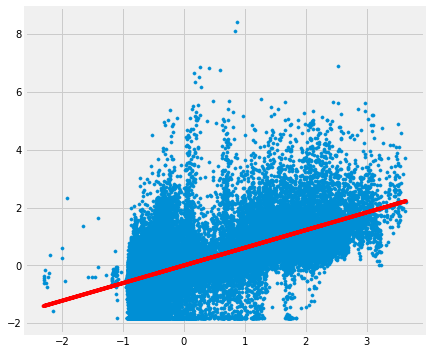

In [81]:
col_name = 'CH_18'

y1 = np.log10(sub_df_xrs['xrsa_flux'])
y2 = np.log10(sub_df_xrs['xrsb_flux'])
x = sub_df_euv[col_name]

# Check for and remove invalid data points
invalid_indices = np.isnan(x) | np.isnan(y1) | np.isnan(y2) | np.isinf(x) | np.isinf(y1) | np.isinf(y2)
x = x[~invalid_indices]
y1 = y1[~invalid_indices]
y2 = y2[~invalid_indices]

# Scale the data
x_mean = np.mean(x)
x_std = np.std(x)
y1_mean = np.mean(y1)
y1_std = np.std(y1)
y2_mean = np.mean(y2)
y2_std = np.std(y2)

x_scaled = (x - x_mean) / x_std
y1_scaled = (y1 - y1_mean) / y1_std
y2_scaled = (y2 - y2_mean) / y2_std

fig = plt.figure(figsize=[14, 6])
ax = fig.add_subplot(121)
ax.scatter(x_scaled, y1_scaled, s=10)

m1, b1 = np.polyfit(x_scaled, y1_scaled, 1)
r_val1 = np.corrcoef(x_scaled, y1_scaled)
ax.plot(x_scaled, m1 * x_scaled + b1, '-r', label=f'R = {r_val1[0, 1]:.2f}')
plt.show()